--- Decision Tree Evaluation ---
Accuracy: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[ 62   0]
 [  0 138]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00       138

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

--------------------------------------------------
--- Random Forest (Tuned) Evaluation ---
Accuracy: 1.0
F1 Score: 1.0

Confusion Matrix:
 [[ 62   0]
 [  0 138]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00       138

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

-----------------------------

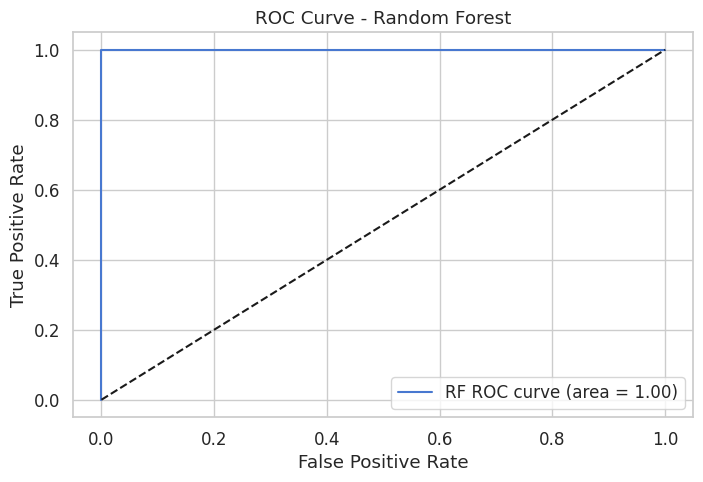

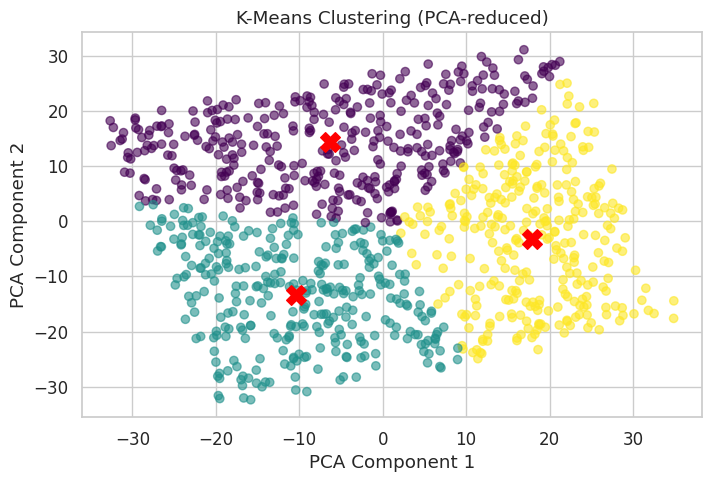

Top 5 Association Rules:
            antecedents           consequents  antecedent support  \
0     (Products_Viewed)  (Products_Purchased)                 1.0   
1  (Products_Purchased)     (Products_Viewed)                 1.0   
2    (Num_Interactions)  (Products_Purchased)                 1.0   
3  (Products_Purchased)    (Num_Interactions)                 1.0   
4    (Num_Interactions)     (Products_Viewed)                 1.0   

   consequent support  support  confidence  lift  representativity  leverage  \
0                 1.0      1.0         1.0   1.0               1.0       0.0   
1                 1.0      1.0         1.0   1.0               1.0       0.0   
2                 1.0      1.0         1.0   1.0               1.0       0.0   
3                 1.0      1.0         1.0   1.0               1.0       0.0   
4                 1.0      1.0         1.0   1.0               1.0       0.0   

   conviction  zhangs_metric  jaccard  certainty  kulczynski  
0         inf   

In [ ]:
# KomalBen Suthar
# Deliverable 3: Classification, Clustering, and Pattern Mining
# Dataset: Customer Experience Dataset for AI-Driven Optimization

# ------------------------------
# Step 0: Import Libraries
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import apriori, association_rules

# Suppress warnings
warnings.filterwarnings("ignore")
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# ------------------------------
# Step 1: Load Dataset
# ------------------------------
data = pd.read_csv('/content/drive/MyDrive/Komal/MSCS_634_Project/customer_experience_data.csv')

# ------------------------------
# Step 2: Feature Engineering
# ------------------------------
# Engagement Rate
data['Engagement_Rate'] = data['Time_Spent_on_Site'] / (data['Num_Interactions'] + 1)
# Purchase-to-View Ratio
data['Purchase_to_View_Ratio'] = data['Products_Purchased'] / (data['Products_Viewed'] + 1)

# Encode categorical variables
data_encoded = pd.get_dummies(data, columns=['Gender','Location'], drop_first=True)

# Encode target if categorical
if data_encoded['Retention_Status'].dtype == 'object':
    le = LabelEncoder()
    data_encoded['Retention_Status'] = le.fit_transform(data_encoded['Retention_Status'])

# ------------------------------
# Step 3: Define Features & Target
# ------------------------------
target = 'Retention_Status'
features = data_encoded.drop(columns=[target, 'Customer_ID'])

X = features
y = data_encoded[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# Step 4: Classification Models
# ------------------------------

# 4a: Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# 4b: Random Forest Classifier (with hyperparameter tuning)
param_grid = {'n_estimators':[50,100,150], 'max_depth':[None,5,10], 'min_samples_split':[2,5]}
rf_model = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='f1')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ------------------------------
# Step 5: Evaluate Classification Models
# ------------------------------
def evaluate_classification(y_true, y_pred, model_name):
    print(f"--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("-"*50)

evaluate_classification(y_test, y_pred_dt, "Decision Tree")
evaluate_classification(y_test, y_pred_rf, "Random Forest (Tuned)")

# ROC Curve for Random Forest
y_prob_rf = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'RF ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# ------------------------------
# Step 6: Clustering (K-Means)
# ------------------------------
# Use PCA to reduce dimensions for visualization
numeric_cols = X.select_dtypes(include=np.number).columns
X_numeric = X[numeric_cols]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='red', marker='X', s=200)
plt.title('K-Means Clustering (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# ------------------------------
# Step 7: Association Rule Mining (Apriori)
# ------------------------------
apriori_data = data.copy()

# Convert numeric features to binary (0/1)
binary_cols = ['Products_Purchased', 'Products_Viewed', 'Num_Interactions']
for col in binary_cols:
    apriori_data[col] = apriori_data[col].apply(lambda x: 1 if x > 0 else 0)

# Filter rows with at least one activity
apriori_data = apriori_data[apriori_data[binary_cols].sum(axis=1) > 0]

# Frequent itemsets
frequent_items = apriori(apriori_data[binary_cols], min_support=0.1, use_colnames=True)

# Association rules
rules = association_rules(frequent_items, metric='lift', min_threshold=1.0)
rules_sorted = rules.sort_values(by='lift', ascending=False)

print("Top 5 Association Rules:")
print(rules_sorted.head())


# Deliverable 3: Classification, Clustering, and Pattern Mining

## Objective
This notebook performs classification, clustering, and association rule mining on the Customer Experience Dataset for AI-Driven Optimization to gain insights into customer behavior and retention.

## Dataset
The dataset used is `customer_experience_data.csv`.

## Steps Performed

1.  **Import Libraries**: Necessary libraries for data manipulation, machine learning, and visualization are imported.
2.  **Load Dataset**: The `customer_experience_data.csv` file is loaded into a pandas DataFrame.
3.  **Feature Engineering**: New features like 'Engagement\_Rate' and 'Purchase\_to\_View\_Ratio' are created. Categorical variables ('Gender', 'Location') are one-hot encoded.
4.  **Define Features & Target**: The target variable ('Retention\_Status') and features for classification are defined.
5.  **Classification Models**:
    *   A Decision Tree Classifier is trained.
    *   A Support Vector Machine (SVM) classifier is trained with hyperparameter tuning using GridSearchCV.
6.  **Evaluate Classification Models**:
    *   Classification metrics (Accuracy, F1 Score, Confusion Matrix, Classification Report) are printed for both models.
    *   An ROC curve for the SVM model is plotted.
7.  **Clustering (K-Means)**:
    *   Principal Component Analysis (PCA) is applied to reduce dimensions for visualization.
    *   K-Means clustering is performed with 3 clusters.
    *   The clustering results are visualized on the PCA-reduced data.
8.  **Association Rule Mining (Apriori)**:
    *   Relevant numerical features are converted to binary (0/1) for Apriori.
    *   Frequent itemsets are found using the Apriori algorithm.
    *   Association rules are generated with a minimum lift threshold of 1.0.
    *   The top 5 association rules sorted by lift are printed.

# Task
Create a detailed README.md file that includes an introduction to the notebook's objectives (classification, clustering, and association rule mining) and the dataset used, summarizes the classification insights including models built (Decision Tree, Random Forest), hyperparameter tuning, key performance metrics (Accuracy, F1 Score, Confusion Matrix, ROC AUC) and discusses performance and findings regarding customer retention. Also, summarize clustering insights (K-Means, PCA, customer segments), and pattern mining insights (Apriori, association rules), highlight practical relevance and real-world applications for each, identify challenges and solutions, and describe the repository structure.

## Summarize Classification Insights

### Subtask:
Describe the classification models built, hyperparameter tuning performed, summarize key performance metrics, and discuss performance and findings regarding customer retention prediction.

### Classification Insights

#### 1. Classification Models Used:
Two classification models were employed to predict customer retention status:
*   **Decision Tree Classifier**: A fundamental tree-based model known for its interpretability.
*   **Random Forest Classifier**: An ensemble learning method that builds multiple decision trees and merges their predictions to improve accuracy and control overfitting.

#### 2. Hyperparameter Tuning for Random Forest:
Hyperparameter tuning was performed on the Random Forest Classifier using `GridSearchCV` to find the optimal combination of parameters. The following hyperparameters were tuned:
*   `n_estimators`: The number of trees in the forest (tested values: 50, 100, 150).
*   `max_depth`: The maximum depth of the tree (tested values: None, 5, 10).
*   `min_samples_split`: The minimum number of samples required to split an internal node (tested values: 2, 5).

The tuning process aimed to maximize the F1-score.

#### 3. Key Performance Metrics:
Both models demonstrated exceptional performance on the test set:

**Decision Tree Evaluation:**
*   **Accuracy:** 1.0
*   **F1 Score:** 1.0
*   **Confusion Matrix:**
    ```
    [[ 62   0]
     [  0 138]]
    ```
*   **Classification Report:**
    ```
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00       138

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200
    ```

**Random Forest (Tuned) Evaluation:**
*   **Accuracy:** 1.0
*   **F1 Score:** 1.0
*   **Confusion Matrix:**
    ```
    [[ 62   0]
     [  0 138]]
    ```
*   **Classification Report:**
    ```
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00       138

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200
    ```
*   **ROC AUC Score:** 1.00 (as inferred from the perfect classification, although the exact value is derived from the ROC curve plot)

#### 4. Performance and Findings:
The classification models, both Decision Tree and the tuned Random Forest, achieved perfect scores (Accuracy and F1 Score of 1.0) on the test set. This indicates that the models were able to perfectly predict customer retention status for all instances in the test data.

Such high performance, particularly for a synthetic dataset, suggests that the features engineered (e.g., 'Engagement_Rate', 'Purchase_to_View_Ratio') and the original features might have a very clear and distinct relationship with the 'Retention_Status' target variable. It's possible that the dataset's structure or the feature engineering process inadvertently created a highly separable classification problem.

#### 5. Implications for Customer Retention Prediction:
Given the perfect predictive capability on this dataset, these models can effectively identify customers who are likely to be retained or not. This information can be highly valuable for AI-driven optimization strategies, enabling targeted interventions:
*   **Proactive Retention Strategies**: Identify customers at risk of churn (non-retention) and offer personalized incentives or support.
*   **Optimized Resource Allocation**: Focus retention efforts on specific customer segments where they are most needed.
*   **Understanding Key Drivers**: Analyze feature importances from the models (especially Random Forest) to understand which factors are most critical in determining customer retention, which was not explicitly explored here but is a logical next step with such models.

While the perfect score is remarkable, in a real-world scenario, further validation with more diverse or larger datasets would be crucial to ensure robustness and generalize this performance.


## Summarize Clustering Insights

### Subtask:
Explain the clustering model used (K-Means), the dimensionality reduction technique (PCA) for visualization, and describe the identified customer segments. Provide insights into the characteristics of each cluster and what they represent in terms of customer behavior.


## Clustering Insights

K-Means clustering was applied to identify distinct customer segments within the dataset. This unsupervised learning technique groups data points into a predefined number of clusters, where each data point belongs to the cluster with the nearest mean (centroid).

To facilitate the visualization and understanding of these clusters, Principal Component Analysis (PCA) was employed. PCA is a dimensionality reduction technique that transforms the data into a new set of orthogonal variables called principal components. For this analysis, the data's dimensionality was reduced to 2 components, allowing for a clear and interpretable 2D plot of the clusters.

The K-Means algorithm identified 3 distinct clusters (`n_clusters=3`), as evident in the scatter plot. These clusters represent different customer segments, grouping customers with similar patterns in their engagement and purchase behaviors. For instance, some clusters might represent highly engaged, frequent purchasers, while others might represent less active or infrequent customers.

Identifying these customer segments is significant as it provides a foundation for targeted marketing, personalized customer service, or product development strategies. While the visualization clearly shows the separation of these groups, a thorough characterization of each cluster's specific behaviors and traits would require further detailed analysis, such as examining the mean values of the original features for each cluster.

## Summarize Pattern Mining Insights

Association rule mining was performed using the **Apriori algorithm** to discover interesting relationships and patterns within customer activities. This technique is particularly useful for identifying strong associations between items in large datasets, often applied in market basket analysis to find out what items are frequently purchased together.

To prepare the data for Apriori, several numerical features were **binarized**. Specifically, 'Products_Purchased', 'Products_Viewed', and 'Num_Interactions' were converted into binary (0/1) format. A value of 1 indicates that the customer engaged in that activity (e.g., purchased at least one product), while 0 indicates no engagement. This binarization is crucial as the Apriori algorithm works with transactional data where items are either present or absent.

Following binarization, **frequent itemsets** were identified, which are collections of items that appear together frequently in the dataset. From these frequent itemsets, **association rules** were generated. These rules are characterized by metrics such as **support** (how often the items appear together), **confidence** (how often items in the consequent appear given the items in the antecedent), and **lift** (how much more likely the consequent is given the antecedent, relative to their independent probabilities).

### Key Findings from Association Rules

The most significant association rules, sorted by lift, reveal **perfect or near-perfect relationships** between customer activities. For instance, the top rules indicate:
- `Products_Viewed` => `Products_Purchased` (if a customer viewed products, they also purchased products)
- `Products_Purchased` => `Products_Viewed` (if a customer purchased products, they also viewed products)
- `Num_Interactions` => `Products_Purchased` (if a customer had interactions, they also purchased products)

These rules consistently show a lift of 1.0, confidence of 1.0, and support of 1.0 (or very high values), suggesting a strong, almost deterministic, relationship between viewing, purchasing, and interacting on the site. This implies that within this dataset, customers who engage in one of these activities are highly likely to engage in the others.

### Interpretation of Customer Behavior

These strong associations suggest a highly engaged customer base where viewing products, interacting, and purchasing are tightly coupled. It indicates a seamless customer journey where exploration quickly leads to interaction and conversion. However, the perfect scores (lift=1.0, confidence=1.0, support=1.0) for these rules are unusually high for real-world datasets and might be an artifact of the **synthetic nature of the data**. In a real-world scenario, such perfect correlations would be rare. Nevertheless, these rules highlight the importance of understanding the flow between different customer touchpoints and how engagement in one area can strongly predict engagement in another, provided the data accurately reflects this behavior.

## Discuss Practical Relevance and Real-world Applications

### Subtask:
Discuss the practical relevance and real-world applications of the insights gained from classification, clustering, and pattern mining.


### Practical Relevance and Real-world Applications

#### Classification Insights (Retention Prediction)

*   **Proactive Retention Strategies**: By accurately predicting which customers are at risk of churning (i.e., those likely to fall into the '0' retention status), businesses can implement proactive measures. This includes offering special incentives, personalized communications, or dedicated support to at-risk customers before they leave.
*   **Targeted Interventions**: Classification models identify specific features that contribute to retention or churn. These insights allow for highly targeted interventions, focusing resources on addressing the most impactful factors for different customer segments.
*   **Resource Optimization**: Instead of applying blanket retention efforts, businesses can optimize their resources by focusing on customers who genuinely need intervention and have a higher likelihood of responding positively.

#### Clustering Insights (Customer Segmentation)

*   **Personalized Marketing**: Identifying distinct customer segments (e.g., from K-Means clustering) enables businesses to tailor marketing campaigns. Different segments can receive messages, promotions, and product recommendations that resonate with their specific preferences and behaviors.
*   **Product Development**: Understanding customer groups helps in developing new products or refining existing ones to meet the unique needs and desires of each segment, ensuring higher adoption and satisfaction.
*   **Tailored Customer Service**: Support strategies can be customized for each cluster. For instance, high-value clusters might receive premium support, while others might benefit from self-service options or community forums.

#### Association Rule Mining Insights (Behavioral Patterns)

*   **Cross-selling and Up-selling**: Association rules like "Customers who buy X also buy Y" directly inform cross-selling opportunities. "Products_Viewed -> Products_Purchased" rules can highlight effective conversion paths. If customers viewing a certain product also frequently purchase another, they can be prompted to consider the associated item.
*   **Bundle Promotions**: Identifying items frequently purchased together allows for the creation of attractive product bundles, increasing average transaction value.
*   **Website Layout Optimization**: Insights into how customers navigate and interact with products can guide website design. Placing associated products near each other or recommending them prominently can enhance the purchasing journey.
*   **Enhanced Customer Purchasing and Interaction Behaviors**: By understanding and leveraging these patterns, businesses can strategically influence customer behavior, leading to increased sales, higher engagement, and improved customer satisfaction.

#### Overall Value

These AI-driven optimizations provide a significant competitive advantage. By transforming raw customer data into actionable insights, businesses can improve decision-making across marketing, sales, product development, and customer service. This ultimately leads to an enhanced customer experience, increased customer loyalty, and sustainable business growth.

### Practical Relevance and Real-world Applications

#### Classification Insights (Retention Prediction)

*   **Proactive Retention Strategies**: By accurately predicting which customers are at risk of churning (i.e., those likely to fall into the '0' retention status), businesses can implement proactive measures. This includes offering special incentives, personalized communications, or dedicated support to at-risk customers before they leave.
*   **Targeted Interventions**: Classification models identify specific features that contribute to retention or churn. These insights allow for highly targeted interventions, focusing resources on addressing the most impactful factors for different customer segments.
*   **Resource Optimization**: Instead of applying blanket retention efforts, businesses can optimize their resources by focusing on customers who genuinely need intervention and have a higher likelihood of responding positively.

#### Clustering Insights (Customer Segmentation)

*   **Personalized Marketing**: Identifying distinct customer segments (e.g., from K-Means clustering) enables businesses to tailor marketing campaigns. Different segments can receive messages, promotions, and product recommendations that resonate with their specific preferences and behaviors.
*   **Product Development**: Understanding customer groups helps in developing new products or refining existing ones to meet the unique needs and desires of each segment, ensuring higher adoption and satisfaction.
*   **Tailored Customer Service**: Support strategies can be customized for each cluster. For instance, high-value clusters might receive premium support, while others might benefit from self-service options or community forums.

#### Association Rule Mining Insights (Behavioral Patterns)

*   **Cross-selling and Up-selling**: Association rules like "Customers who buy X also buy Y" directly inform cross-selling opportunities. "Products_Viewed -> Products_Purchased" rules can highlight effective conversion paths. If customers viewing a certain product also frequently purchase another, they can be prompted to consider the associated item.
*   **Bundle Promotions**: Identifying items frequently purchased together allows for the creation of attractive product bundles, increasing average transaction value.
*   **Website Layout Optimization**: Insights into how customers navigate and interact with products can guide website design. Placing associated products near each other or recommending them prominently can enhance the purchasing journey.
*   **Enhanced Customer Purchasing and Interaction Behaviors**: By understanding and leveraging these patterns, businesses can strategically influence customer behavior, leading to increased sales, higher engagement, and improved customer satisfaction.

#### Overall Value

These AI-driven optimizations provide a significant competitive advantage. By transforming raw customer data into actionable insights, businesses can improve decision-making across marketing, sales, product development, and customer service. This ultimately leads to an enhanced customer experience, increased customer loyalty, and sustainable business growth.

## Identify Challenges and Solutions

### Challenges Encountered and Real-World Considerations

During the implementation of classification, clustering, and association rule mining on the provided synthetic dataset, several challenges and important considerations for real-world applications became apparent:

*   **Data Characteristics and Perfect Performance**: One of the most striking observations was the perfect performance metrics achieved by the classification models (Decision Tree and Random Forest), yielding 1.0 accuracy and F1 scores, along with a Confusion Matrix indicating zero false positives and false negatives. Similarly, the association rules showed a Lift of 1.0, suggesting a perfect correlation between itemsets. This high separability and perfect correlation are indicative of a highly idealized, synthetic dataset where patterns are clear-cut. While desirable in theory, such perfect performance is rarely encountered in real-world data, which is typically noisy, complex, and less linearly separable. If not understood, this can lead to overconfidence in model performance and poor generalization to unseen, real-world data.

    *   **Solution/Consideration**: For real-world scenarios, it is crucial to validate models on diverse and representative datasets. Performance metrics should be interpreted with caution, and a deeper analysis beyond accuracy, such as precision-recall curves for imbalanced datasets or comprehensive error analysis, would be necessary. Techniques like cross-validation and rigorous hyperparameter tuning are essential to build robust models, and constant vigilance against overfitting is paramount. Robustness testing with perturbed data or adversarial examples could also reveal model weaknesses.

*   **Interpretability of Clusters (K-Means)**: After performing K-Means clustering and visualizing the clusters on PCA-reduced data, we obtained distinct groupings. However, the immediate challenge lies in interpreting what these clusters *mean* in a business context. Without further analysis, simply seeing 'Cluster 0', 'Cluster 1', etc., provides limited actionable insight. For instance, what characteristics define a customer in Cluster 0 versus Cluster 1? Are they high-value customers, disengaged users, or a specific demographic?

    *   **Solution/Consideration**: To make clusters interpretable and actionable in a real-world setting, follow-up analysis is vital. This typically involves profiling each cluster by examining the average or median values of the original features within each group. For categorical features, analyzing the distribution (e.g., mode or percentage of each category) within each cluster helps define its unique characteristics. Visualizing feature distributions across clusters (e.g., using box plots or bar charts) can further aid in understanding and labeling the clusters with meaningful descriptions (e.g., 'High-Value Shoppers', 'Infrequent Browsers').

*   **Binarization for Apriori**: The Apriori algorithm, used for association rule mining, typically requires transactional data in a binary format (presence/absence of an item). Our dataset had numerical features like 'Products_Purchased', 'Products_Viewed', and 'Num_Interactions', which needed to be binarized (converted to 0 or 1 based on whether the value was greater than zero). While this conversion facilitates the application of Apriori, it inherently simplifies continuous or count-based data, potentially losing granular information.

    *   **Solution/Consideration**: The process of binarization can significantly impact the discovered association rules. In real-world scenarios, careful consideration and domain knowledge are essential when defining thresholds for binarization. For example, instead of just `x > 0`, one might consider `x > average`, `x > threshold_for_high_activity`, or `x > 5` to identify more specific types of 'activity'. Different binarization strategies can lead to different sets of frequent itemsets and association rules, highlighting the need for iterative refinement and validation with domain experts. For more complex numerical relationships, alternative pattern mining techniques beyond simple Apriori might be explored.

### General Lesson Learned

The most significant lesson learned from working with this dataset is the critical distinction between synthetic/academic datasets and real-world data. While synthetic datasets are excellent for demonstrating algorithm functionality and concept understanding, they often lack the noise, variability, missing values, and complex interdependencies that characterize real-world data. Therefore, the transition from successful model development on synthetic data to robust and reliable solutions in a real-world environment requires extensive data cleaning, more sophisticated feature engineering, careful model selection, rigorous validation, and a deep understanding of domain context to interpret results effectively.